#### Chapter 13: Dynamic Hedging

* If you have constant volatility, continuous price paths, costless transactions, and thus the only source of risk is the underlying asset price movement, dynamic delta hedging is 'easy'
* This describes no market or asset
* The Delta of a put option is defined by the first derivative of the option value with respec to the value of the underlying S
* Delta hedging the put P neutralizes the price changes in the put option due to changes in the underlying

* Institutions, who write options contracts, have incentives to replicate such payoffs so they can also be neutral to such price movements
* Replication strategy is self-financing if there are neither cash-inflows nor cash-outflows after t=0

* Implement approximation delta hedge algorithm for American options that recycles the coefficients from an Least Square Monte Carlo

* Delta hedging cannot account for jumps and so will not perform well where source of risk is coming from places other than index risk (i.e. jump risk)

In [1]:

#
# Dynamic Hedging of American Put Option in BSM Model
# with Least Squares Monte Carlo
# 13_dyh/BSM_lsm_hedging_algorithm.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'serif'
#
# Parameters
#
S0 = 36.0  # initial stock value
K = 40.0  # strike price
T = 1.0  # time to maturity
r = 0.06  # risk-less short rate
sigma = 0.20  # volatility of stock value
M = 50  # number of time steps
I = 50000  # number of paths


#
# Valuation
#
D = 9  # number of regression functions


def BSM_lsm_put_value(S0, M, I):
    ''' Function to value an American put option by LSM algorithm.

    Parameters
    ==========
    S0: float
        initial index level
    M: int
        number of time steps

    Returns
    =======
    V0: float
        LSM Monte Carlo estimator of American put option value
    S: NumPy array
        simulated index level paths
    ex: NumPy array
        exercise matrix
    rg: NumPy array
        regression coefficients
    h: NumPy array
        inner value matrix
    dt: float
        length of time interval
    '''
    rand = np.random.standard_normal((M + 1, I))  # random numbers
    dt = T / M   # length of time interval
    df = math.exp(-r * dt)  # discount factor
    S = np.zeros((M + 1, I), dtype=np.float)  # stock price matrix
    S[0] = S0  # initial values
    for t in range(1, M + 1, 1):  # stock price at t
        S[t] = S[t - 1] * (np.exp((r - sigma ** 2 / 2) * dt +
                                  sigma * math.sqrt(dt) * rand[t]))
    h = np.maximum(K - S, 0)  # inner values
    V = np.maximum(K - S, 0)  # value matrix
    ex = np.zeros((M + 1, I), dtype=np.float)   # exercise matrix
    C = np.zeros((M + 1, I), dtype=np.float)   # continuation value matrix
    rg = np.zeros((M + 1, D + 1), dtype=np.float)
    # matrix for reg. coefficients
    for t in range(M - 1, 0, -1):
        rg[t] = np.polyfit(S[t], V[t + 1] * df, D)
        # regression in step i
        C[t] = np.polyval(rg[t], S[t])
        # estimated continuation values
        C[t] = np.where(C[t] < 0, 0., C[t])
        # correction for neg C
        V[t] = np.where(h[t] >= C[t],
                        h[t], V[t + 1] * df)  # exercise decision
        ex[t] = np.where(h[t] >= C[t], 1, 0)
        # exercise decision (yes=1)
    V0 = np.sum(V[1]) / I * df
    return V0, S, ex, rg, h, dt


def BSM_hedge_run(p=0):
    ''' Implements delta hedging for a single path. '''
    np.random.seed(50000)
    #
    # Initial Delta
    #
    ds = 0.01
    V_1, S, ex, rg, h, dt = BSM_lsm_put_value(S0 + ds, M, I)
    V_2 = BSM_lsm_put_value(S0, M, I)[0]
    del_0 = (V_1 - V_2) / ds

    #
    # Dynamic Hedging
    #
    delt = np.zeros(M + 1, dtype=np.float)  # vector for deltas
    print
    print("APPROXIMATION OF FIRST ORDER ")
    print("-----------------------------")
    print(" %7s | %7s | %7s " % ('step', 'S_t', 'Delta'))
    for t in range(1, M, 1):
        if ex[t, p] == 0:  # if option is alive
            St = S[t, p]  # relevant index level
            diff = (np.polyval(rg[t], St + ds) -
                    np.polyval(rg[t], St))
            # numerator of difference quotient
            delt[t] = diff / ds  # delta as difference quotient
            print(" %7d | %7.2f | %7.2f" % (t, St, delt[t]))
            if (S[t, p] - S[t - 1, p]) * (delt[t] - delt[t - 1]) < 0:
                print("          wrong")
        else:
            break

    delt[0] = del_0
    print()
    print("DYNAMIC HEDGING OF AMERICAN PUT (BSM)")
    print("---------------------------------------")
    po = np.zeros(t, dtype=np.float)  # vector for portfolio values
    vt = np.zeros(t, dtype=np.float)  # vector for option values
    vt[0] = V_1
    po[0] = V_1
    bo = V_1 - delt[0] * S0  # bond position value
    print("Initial Hedge")
    print("Stocks             %8.3f" % delt[0])
    print("Bonds              %8.3f" % bo)
    print("Cost               %8.3f" % (delt[0] * S0 + bo))

    print()
    print("Regular Rehedges ")
    print(68 * "-")
    print("step|" + 7 * " %7s|" % ('S_t', 'Port', 'Put',
                                   'Diff', 'Stock', 'Bond', 'Cost'))
    for j in range(1, t, 1):
        vt[j] = BSM_lsm_put_value(S[j, p], M - j, I)[0]
        po[j] = delt[j - 1] * S[j, p] + bo * math.exp(r * dt)
        bo = po[j] - delt[j] * S[j, p]  # bond position value
        print("%4d|" % j + 7 * " %7.3f|" % (S[j, p], po[j], vt[j],
                                            (po[j] - vt[j]), delt[j],
                                            bo, delt[j] * S[j, p] + bo))

    errs = po - vt  # hedge errors
    print("MSE             %7.3f" % (np.sum(errs ** 2) / len(errs)))
    print("Average Error   %7.3f" % (np.sum(errs) / len(errs)))
    print("Total P&L       %7.3f" % np.sum(errs))
    return S[:, p], po, vt, errs, t


def plot_hedge_path(S, po, vt, errs, t):
    #
    # Graphical Output
    #
    tl = np.arange(t)
    plt.figure(figsize=(8, 6))
    plt.subplot(311)
    plt.plot(tl, S[tl], 'r')
    plt.ylabel('index level')
    plt.subplot(312)
    plt.grid(True)
    plt.plot(tl, po[tl], 'r-.', label='portfolio value', lw=2)
    plt.plot(tl, vt[tl], 'b', label='option value', lw=1)
    plt.ylabel('value')
    plt.legend(loc=0)
    ax = plt.axis()
    plt.subplot(313)
    wi = 0.3
    diffs = po[tl] - vt[tl]
    plt.bar(tl - wi / 2, diffs, color='b', width=wi)
    plt.ylabel('difference')
    plt.xlabel('time step')
    plt.axis([ax[0], ax[1], min(diffs) * 1.1, max(diffs) * 1.1])
    plt.tight_layout()


In [6]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    S, po, vt, errs, t = BSM_hedge_run(p=25)

APPROXIMATION OF FIRST ORDER 
-----------------------------
    step |     S_t |   Delta 
       1 |   34.97 |   -0.79
       2 |   36.14 |   -0.70
       3 |   36.40 |   -0.67
       4 |   37.61 |   -0.59
       5 |   37.41 |   -0.59
          wrong
       6 |   38.52 |   -0.54
       7 |   39.43 |   -0.48
       8 |   40.09 |   -0.43
       9 |   40.07 |   -0.41
          wrong
      10 |   41.79 |   -0.32
      11 |   41.26 |   -0.33
      12 |   40.22 |   -0.38
      13 |   38.42 |   -0.51
      14 |   37.98 |   -0.57
      15 |   36.79 |   -0.68
      16 |   35.86 |   -0.78
      17 |   34.49 |   -0.90
      18 |   34.48 |   -0.90

DYNAMIC HEDGING OF AMERICAN PUT (BSM)
---------------------------------------
Initial Hedge
Stocks               -0.995
Bonds                40.303
Cost                  4.474

Regular Rehedges 
--------------------------------------------------------------------
step|     S_t|    Port|     Put|    Diff|   Stock|    Bond|    Cost|
   1|  34.968|   5.549

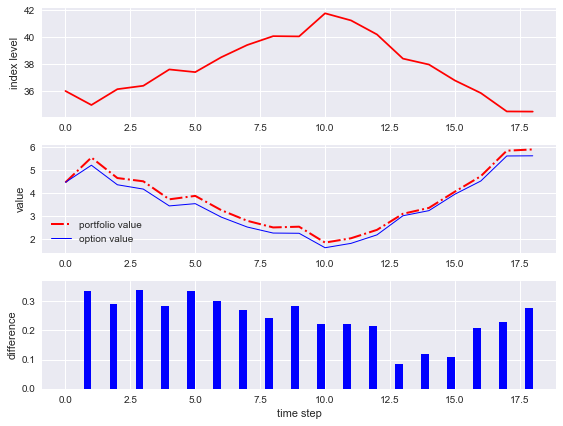

In [7]:
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline
plot_hedge_path(S, po, vt, errs, t)

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    S, po, vt, errs, t = BSM_hedge_run(p=5)

APPROXIMATION OF FIRST ORDER 
-----------------------------
    step |     S_t |   Delta 
       1 |   35.31 |   -0.75
       2 |   36.25 |   -0.69
       3 |   37.50 |   -0.61
       4 |   35.98 |   -0.69
       5 |   36.52 |   -0.65
       6 |   35.98 |   -0.70
       7 |   35.55 |   -0.75
       8 |   35.89 |   -0.72
       9 |   38.18 |   -0.53
      10 |   38.25 |   -0.52
      11 |   38.00 |   -0.54
      12 |   37.80 |   -0.56
      13 |   39.22 |   -0.45
      14 |   39.54 |   -0.44
      15 |   39.82 |   -0.42
      16 |   39.29 |   -0.46
      17 |   38.11 |   -0.56
      18 |   38.10 |   -0.57
      19 |   39.61 |   -0.43
      20 |   40.22 |   -0.39
      21 |   39.78 |   -0.43
      22 |   39.90 |   -0.42
      23 |   39.82 |   -0.44
      24 |   41.30 |   -0.32
      25 |   42.60 |   -0.23
      26 |   42.86 |   -0.21
      27 |   44.64 |   -0.13
      28 |   42.78 |   -0.22
      29 |   42.22 |   -0.26
      30 |   42.15 |   -0.27
      31 |   41.36 |   -0.33
      32 | 

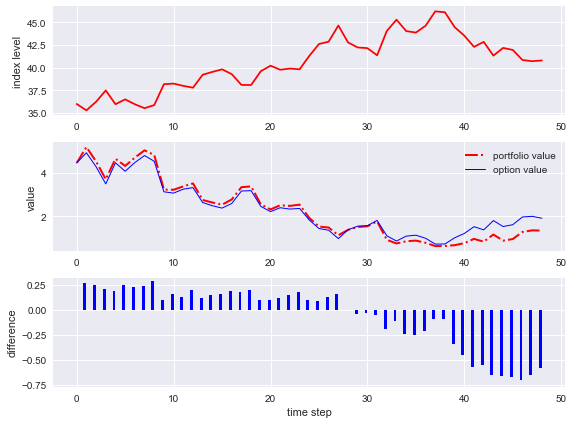

In [9]:
plot_hedge_path(S, po, vt, errs, t)

In [11]:
#
# Dynamic Hedging of American Put Option in BSM Model
# with Least Squares Monte Carlo -- Histogram
# 13_dyh/BSM_lsm_hedging_histogram.py
#
# (c) Dr. Yves s. Hilpisch
# Derivatives Analytics with Python
#


def BSM_dynamic_hedge_mcs(M=50, I=10000):
    ''' Monte Carlo simualtion of dynamic hedging paths
    for American put option in BSM model. '''
    #
    # Initial Delta
    #
    ds = 0.01
    V_1, S, ex, rg, h, dt = BSM_lsm_put_value(S0 + ds, M, I)
    V_2 = BSM_lsm_put_value(S0, M, I)[0]
    del_0 = (V_1 - V_2) / ds

    print("Value of American Put Option is %8.3f" % V_2)
    print("Delta t=0 is                    %8.3f" % del_0)
    #
    # Dynamic Hedging Runs
    #
    pl_list = []
    run = 0
    runs = min(I, 10000)
    for run in range(runs):
        p = run
        run += 1
        delta = np.zeros(M + 1, dtype=np.float)  # vector for deltas
        for t in range(0, M, 1):
            if ex[t - 1, p] == 0:  # if option is alive
                St = S[t, p]  # relevant index level
                diff = (np.polyval(rg[t, :], St + ds) -
                        np.polyval(rg[t, :], St))
                # numerator of difference quotient
                delta[t] = diff / ds  # delta as difference quotient
            else:
                break
        delta[0] = del_0
        po = np.zeros(t, dtype=np.float)  # vector for portfolio values
        vt = np.zeros(t, dtype=np.float)  # vector for option values
        vt[0] = V_2  # initial option value
        po[0] = V_2  # initial portfolio value
        bo = V_2 - delta[0] * S0  # initial bond position value
        for s in range(1, t, 1):  # for all times up to i-1
            po[s] = delta[s - 1] * S[s, p] + bo * math.exp(r * dt)
            # portfolio payoff
            bo = po[s] - delta[s] * S[s, p]  # bond position value
            if s == t - 1:  # at exercise/expiration date
                vt[s] = h[s, p]  # option value equals inner value
                pl = (po[s] - vt[s]) * math.exp(-r * t * dt)
                # discounted difference between option and portfolio value
                if run % 1000 == 0:
                    print("run %5d   p/l %8.3f" % (run, pl))
                pl_list.append(pl)  # collect all differences
    pl_list = np.array(pl_list)

    #
    # Summary Results Output
    #
    print("\nSUMMARY STATISTICS FOR P&L")
    print("---------------------------------")
    print("Dynamic Replications %12d" % runs)
    print("Time Steps           %12d" % M)
    print("Paths for Valuation  %12d" % I)
    print("Maximum              %12.3f" % max(pl_list))
    print("Average              %12.3f" % np.mean(pl_list))
    print("Median               %12.3f" % np.median(pl_list))
    print("Minimum              %12.3f" % min(pl_list))
    print("---------------------------------")

    return pl_list


def plot_hedge_histogram(pl_list):
    ''' Plot of P/L histogram. '''
    #
    # Graphical Output
    #
    plt.figure(figsize=(8, 6))
    plt.hist(pl_list, 75)
    plt.xlabel('profit/loss')
    plt.ylabel('frequency')


In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %time pl_list = BSM_dynamic_hedge_mcs()

Value of American Put Option is    4.482
Delta t=0 is                      -0.254
run  1000   p/l    0.353
run  2000   p/l    0.496
run  3000   p/l   -0.833
run  4000   p/l   -1.069
run  5000   p/l    0.334
run  6000   p/l   -1.743
run  7000   p/l   -0.117
run  8000   p/l    0.087
run  9000   p/l    0.190
run 10000   p/l   -0.288

SUMMARY STATISTICS FOR P&L
---------------------------------
Dynamic Replications        10000
Time Steps                     50
Paths for Valuation         10000
Maximum                     5.428
Average                     0.043
Median                      0.040
Minimum                    -7.927
---------------------------------
CPU times: user 5.57 s, sys: 480 ms, total: 6.05 s
Wall time: 5.27 s


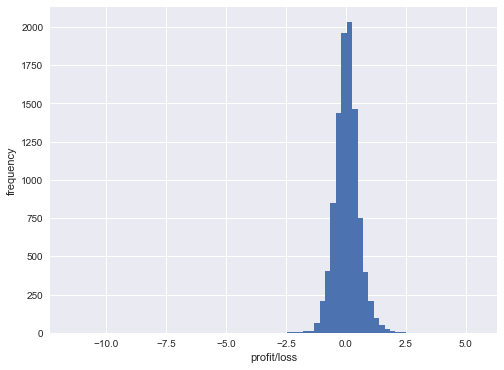

In [13]:
plot_hedge_histogram(pl_list)

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %time pl_list = BSM_dynamic_hedge_mcs(M=200, I=150000) 

Value of American Put Option is    4.468
Delta t=0 is                      -0.435
run  1000   p/l    0.098
run  2000   p/l   -0.282
run  3000   p/l    0.066
run  4000   p/l   -0.419
run  5000   p/l    0.242
run  6000   p/l    0.555
run  7000   p/l   -0.117
run  8000   p/l    0.255
run  9000   p/l    0.152
run 10000   p/l   -0.173

SUMMARY STATISTICS FOR P&L
---------------------------------
Dynamic Replications        10000
Time Steps                    200
Paths for Valuation        150000
Maximum                     1.367
Average                     0.011
Median                      0.005
Minimum                    -3.990
---------------------------------
CPU times: user 47.6 s, sys: 3.61 s, total: 51.2 s
Wall time: 35.9 s


In [18]:
#
# Delta Hedging an American Put Option in BCC97
# via Least Squares Monte Carlo (Multiple Replications)
# 13_dyh/BCC97_lsm_hedging_algorithm.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys
import math
import numpy as np
import matplotlib as mpl

sys.path.extend(['09_gmm', '11_cal', '12_val'])
from H93_calibration import S0, kappa_r, theta_r, sigma_r, r0
from BCC97_simulation import *
# from BSM_lsm_hedging_algorithm import plot_hedge_path

mpl.rcParams['font.family'] = 'serif'
#
# Model Parameters
#
opt = np.load('11_cal/opt_full.npy')
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = opt

#
# Simulation
#
K = S0
T = 1.0
M = 50
I = 50000
a = 1.0  # a from the interval [0.0, 2.0]
dis = 0.01  # change of S[t] in percent to estimate derivative
dt = T / M
moment_matching = True


def BCC97_lsm_put_value(S0, K, T, M, I):
    ''' Function to value American put options by LSM algorithm.

    Parameters
    ==========
    S0: float
        intial index level
    K: float
        strike of the put option
    T: float
        final date/time horizon
    M: int
        number of time steps
    I: int
        number of paths

    Returns
    =======
    V0: float
        LSM Monte Carlo estimator of American put option value
    S: NumPy array
        simulated index level paths
    r: NumPy array
        simulated short rate paths
    v: NumPy array
        simulated variance paths
    ex: NumPy array
        exercise matrix
    rg: NumPy array
        regression coefficients
    h: NumPy array
        inner value matrix
    dt: float
        length of time interval
    '''
    dt = T / M
    # Cholesky Matrix
    cho_matrix = generate_cholesky(rho)
    # Random Numbers
    rand = random_number_generator(M, I, anti_paths, moment_matching)
    # Short Rate Process Simulation
    r = SRD_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I,
                           rand, 0, cho_matrix)
    # Variance Process Simulation
    v = SRD_generate_paths(v0, kappa_v, theta_v, sigma_v, T, M, I,
                           rand, 2, cho_matrix)
    # Index Level Process Simulation
    S = B96_generate_paths(S0, r, v, lamb, mu, delta, rand, 1, 3,
                           cho_matrix, T, M, I, moment_matching)
    h = np.maximum(K - S, 0)  # inner value matrix
    V = np.maximum(K - S, 0)  # value/cash flow matrix
    ex = np.zeros_like(V)  # exercise matrix
    D = 10  # number of regression functions
    rg = np.zeros((M + 1, D + 1), dtype=np.float)
    # matrix for regression parameters
    for t in range(M - 1, 0, -1):
        df = np.exp(-(r[t] + r[t + 1]) / 2 * dt)
        # select only ITM paths
        itm = np.greater(h[t], 0)
        relevant = np.nonzero(itm)
        rel_S = np.compress(itm, S[t])
        no_itm = len(rel_S)
        if no_itm == 0:
            cv = np.zeros((I), dtype=np.float)
        else:
            rel_v = np.compress(itm, v[t])
            rel_r = np.compress(itm, r[t])
            rel_V = (np.compress(itm, V[t + 1]) *
                     np.compress(itm, df))
            matrix = np.zeros((D + 1, no_itm), dtype=np.float)
            matrix[10] = rel_S * rel_v * rel_r
            matrix[9] = rel_S * rel_v
            matrix[8] = rel_S * rel_r
            matrix[7] = rel_v * rel_r
            matrix[6] = rel_S ** 2
            matrix[5] = rel_v ** 2
            matrix[4] = rel_r ** 2
            matrix[3] = rel_S
            matrix[2] = rel_v
            matrix[1] = rel_r
            matrix[0] = 1
            rg[t] = np.linalg.lstsq(matrix.transpose(), rel_V)[0]
            cv = np.dot(rg[t], matrix)
        erg = np.zeros((I), dtype=np.float)
        np.put(erg, relevant, cv)
        V[t] = np.where(h[t] > erg, h[t], V[t + 1] * df)
        # value array
        ex[t] = np.where(h[t] > erg, 1, 0)
        # exercise decision
    df = np.exp(-((r[0] + r[1]) / 2) * dt)
    V0 = max(np.sum(V[1, :] * df) / I, h[0, 0])   # LSM estimator
    return V0, S, r, v, ex, rg, h, dt


def BCC97_hedge_run(p):
    ''' Implements delta hedging for a single path. '''
    #
    # Initializations
    #
    np.random.seed(50000)
    po = np.zeros(M + 1, dtype=np.float)  # vector for portfolio values
    vt = np.zeros(M + 1, dtype=np.float)  # vector for option values
    delt = np.zeros(M + 1, dtype=np.float)  # vector for deltas
    # random path selection ('real path')
    print()
    print("DYNAMIC HEDGING OF AMERICAN PUT (BCC97)")
    print("---------------------------------------")
    ds = dis * S0
    V_1, S, r, v, ex, rg, h, dt = BCC97_lsm_put_value(S0 + (2 - a) * ds,
                                                      K, T, M, I)
    # 'data basis' for delta hedging
    V_2 = BCC97_lsm_put_value(S0 - a * ds, K, T, M, I)[0]
    delt[0] = (V_1 - V_2) / (2 * ds)
    V0LSM = BCC97_lsm_put_value(S0, K, T, M, I)[0]
    # initial option value for S0
    vt[0] = V0LSM  # initial option values
    po[0] = V0LSM  # initial portfolio values
    bo = V0LSM - delt[0] * S0  # initial bond position value
    print("Initial Hedge")
    print("Stocks             %8.3f" % delt[0])
    print("Bonds              %8.3f" % bo)
    print("Cost               %8.3f" % (delt[0] * S0 + bo))

    print()
    print("Regular Rehedges ")
    print(82 * "-")
    print("step|" + 7 * " %9s|" % ('S_t', 'Port', 'Put',
                                   'Diff', 'Stock', 'Bond', 'Cost'))
    for t in range(1, M + 1, 1):
        if ex[t, p] == 0:
            df = math.exp((r[t, p] + r[t - 1, p]) / 2 * dt)
            if t != M:
                po[t] = delt[t - 1] * S[t, p] + bo * df
                vt[t] = BCC97_lsm_put_value(S[t, p], K, T - t * dt,
                                            M - t, I)[0]
                ds = dis * S[t, p]
                sd = S[t, p] + (2 - a) * ds  # disturbed index level
                stateV_A = [sd * v[t, p] * r[t, p],
                            sd * v[t, p],
                            sd * r[t, p],
                            v[t, p] * r[t, p],
                            sd ** 2,
                            v[t, p] ** 2,
                            r[t, p] ** 2,
                            sd,
                            v[t, p],
                            r[t, p],
                            1]
                # state vector for S[t, p] + (2.0 - a) * dis
                stateV_A.reverse()
                V0A = max(0, np.dot(rg[t], stateV_A))
                # print V0A
                # revaluation via regression
                sd = S[t, p] - a * ds  # disturbed index level
                stateV_B = [sd * v[t, p] * r[t, p],
                            sd * v[t, p],
                            sd * r[t, p],
                            v[t, p] * r[t, p],
                            sd ** 2,
                            v[t, p] ** 2,
                            r[t, p] ** 2,
                            sd,
                            v[t, p],
                            r[t, p],
                            1]
                # state vector for S[t, p] - a * dis
                stateV_B.reverse()
                V0B = max(0, np.dot(rg[t], stateV_B))
                # print V0B
                # revaluation via regression
                delt[t] = (V0A - V0B) / (2 * ds)
                bo = po[t] - delt[t] * S[t, p]  # bond position value
            else:
                po[t] = delt[t - 1] * S[t, p] + bo * df
                vt[t] = h[t, p]
                # inner value at final date
                delt[t] = 0.0
            print("%4d|" % t + 7 * " %9.3f|" % (S[t, p], po[t], vt[t],
                                                (po[t] - vt[t]), delt[t],
                                                bo, delt[t] * S[t, p] + bo))
        else:
            po[t] = delt[t - 1] * S[t, p] + bo * df
            vt[t] = h[t, p]
            break
    errs = po - vt  # hedge errors
    print("MSE             %7.3f" % (np.sum(errs ** 2) / len(errs)))
    print("Average Error   %7.3f" % (np.sum(errs) / len(errs)))
    print("Total P&L       %7.3f" % np.sum(errs))
    return S[:, p], po, vt, errs, t


In [19]:
S, po, vt, errs, t = BCC97_hedge_run(2)


DYNAMIC HEDGING OF AMERICAN PUT (BCC97)
---------------------------------------
Initial Hedge
Stocks               -0.426
Bonds              1602.498
Cost                228.305

Regular Rehedges 
----------------------------------------------------------------------------------
step|       S_t|      Port|       Put|      Diff|     Stock|      Bond|      Cost|
   1|  3293.090|   199.691|   201.600|    -1.909|    -1.856|  6311.671|   199.691|
   2|  3323.629|   143.027|   186.740|   -43.712|    -0.318|  1201.164|   143.027|
   3|  3352.073|   133.986|   175.533|   -41.547|    -0.358|  1335.492|   133.986|
   4|  3380.280|   123.907|   163.659|   -39.752|    -0.429|  1572.798|   123.907|
   5|  3370.652|   128.084|   165.605|   -37.521|    -0.401|  1481.094|   128.084|
   6|  3398.985|   116.788|   153.569|   -36.781|    -0.381|  1410.163|   116.788|
   7|  3369.633|   128.053|   160.805|   -32.752|    -0.408|  1503.294|   128.053|
   8|  3289.659|   160.744|   187.601|   -26.858|    -0

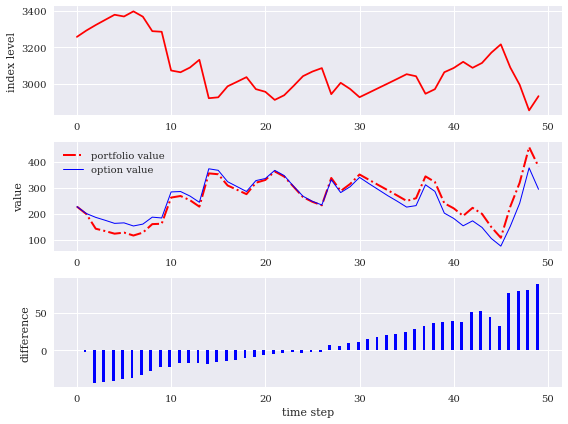

In [20]:
plot_hedge_path(S, po, vt, errs, t)

In [25]:
S, po, vt, errs, t = BCC97_hedge_run(10)


DYNAMIC HEDGING OF AMERICAN PUT (BCC97)
---------------------------------------
Initial Hedge
Stocks               -0.426
Bonds              1602.498
Cost                228.305

Regular Rehedges 
----------------------------------------------------------------------------------
step|       S_t|      Port|       Put|      Diff|     Stock|      Bond|      Cost|
   1|  3279.504|   205.478|   206.743|    -1.265|    -1.840|  6238.141|   205.478|
   2|  3320.067|   130.880|   188.081|   -57.201|    -0.346|  1281.174|   130.880|
   3|  3376.082|   111.482|   167.223|   -55.741|    -0.365|  1344.375|   111.482|
   4|  3361.832|   116.699|   169.228|   -52.529|    -0.397|  1452.837|   116.699|
   5|  3037.992|   245.423|   314.988|   -69.565|    -0.626|  2146.990|   245.423|
   6|  3112.977|   198.501|   270.861|   -72.360|    -0.528|  1841.664|   198.501|
   7|  3163.420|   171.878|   242.932|   -71.054|    -0.523|  1826.509|   171.878|
   8|  3088.687|   210.978|   280.711|   -69.733|    -0

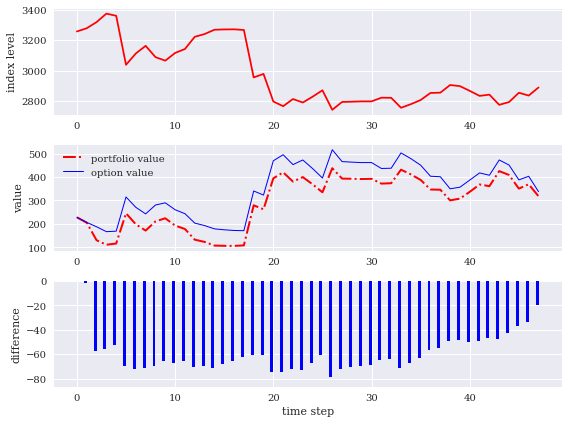

In [26]:
plot_hedge_path(S, po, vt, errs, t + 1)

In [27]:
S, po, vt, errs, t = BCC97_hedge_run(4)


DYNAMIC HEDGING OF AMERICAN PUT (BCC97)
---------------------------------------
Initial Hedge
Stocks               -0.426
Bonds              1602.498
Cost                228.305

Regular Rehedges 
----------------------------------------------------------------------------------
step|       S_t|      Port|       Put|      Diff|     Stock|      Bond|      Cost|
   1|  3334.785|   181.929|   186.347|    -4.418|    -1.787|  6140.884|   181.929|
   2|  3308.847|   228.296|   192.136|    36.160|    -0.353|  1397.161|   228.296|
   3|  3257.391|   246.484|   210.867|    35.617|    -0.450|  1713.090|   246.484|
   4|  3284.768|   234.181|   197.179|    37.002|    -0.426|  1631.875|   234.181|
   5|  3399.651|   185.310|   156.171|    29.138|    -0.350|  1375.014|   185.310|
   6|  3285.852|   225.136|   192.522|    32.614|    -0.425|  1620.463|   225.136|
   7|  3351.304|   197.344|   166.841|    30.503|    -0.411|  1575.848|   197.344|
   8|  3408.658|   173.758|   146.445|    27.312|    -0

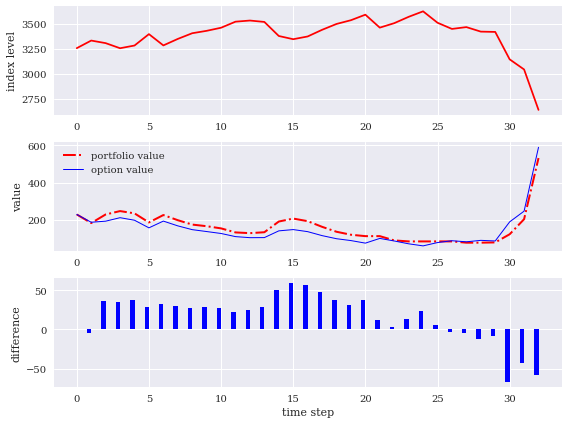

In [28]:
plot_hedge_path(S, po, vt, errs, t + 1)

In [31]:
#
# Delta Hedging an American Put Option in BCC97
# via Least Squares Monte Carlo (Multiple Replications)
# 13_dyh/BCC97_lsm_hedging_histogram.py
#
# (c) Dr. Yves s. Hilpisch
# Derivatives Analytics with Python
#
from CIR_zcb_valuation_gen import B

#
# Simulation
#
T = 1.0
a = 1.0  # a from the interval [0.0, 2.0]
dis = 0.05  # change of S[t] in percent to estimate derivative
dt = T / M
np.random.seed(50000)


def BCC97_hedge_simulation(M=50, I=10000):
    ''' Monte Carlo simualtion of dynamic hedging paths
    for American put option in BSM model. '''
    #
    # Initializations
    #
    po = np.zeros(M + 1, dtype=np.float)  # vector for portfolio values
    delt = np.zeros(M + 1, dtype=np.float)  # vector for deltas
    ds = dis * S0
    V_1, S, r, v, ex, rg, h, dt = BCC97_lsm_put_value(S0 + (2 - a) * ds,
                                                      K, T, M, I)
    # 'data basis' for delta hedging
    V_2 = BCC97_lsm_put_value(S0 - a * ds, K, T, M, I)[0]
    delt[0] = (V_1 - V_2) / (2 * ds)
    # initial option value for S0
    V0LSM = BCC97_lsm_put_value(S0, K, T, M, I)[0]
    po[0] = V0LSM  # initial portfolio values

    #
    # Hedge Runs
    #
    pl_list = []
    runs = min(I, 10000)
    for run in range(runs):
        bo = V0LSM - delt[0] * S0  # initial bond position value
        p = run
        run += 1
        for t in range(1, M + 1, 1):
            if ex[t, p] == 0:
                df = math.exp((r[t, p] + r[t - 1, p]) / 2 * dt)
                if t != M:
                    po[t] = delt[t - 1] * S[t, p] + bo * df  # portfolio payoff
                    ds = dis * S[t, p]
                    sd = S[t, p] + (2 - a) * ds  # disturbed index level
                    stateV_A = [sd * v[t, p] * r[t, p],
                                sd * v[t, p],
                                sd * r[t, p],
                                v[t, p] * r[t, p],
                                sd ** 2,
                                v[t, p] ** 2,
                                r[t, p] ** 2,
                                sd,
                                v[t, p],
                                r[t, p],
                                1]
                    # state vector for S[t, p] + (2.0 - a) * ds
                    stateV_A.reverse()
                    V0A = max(0, np.dot(rg[t], stateV_A))
                    # revaluation via regression
                    sd = S[t, p] - a * ds  # disturbed index level
                    stateV_B = [sd * v[t, p] * r[t, p],
                                sd * v[t, p],
                                sd * r[t, p],
                                v[t, p] * r[t, p],
                                sd ** 2,
                                v[t, p] ** 2,
                                r[t, p] ** 2,
                                sd,
                                v[t, p],
                                r[t, p],
                                1]
                    # state vector for S[t, p] - a * ds
                    stateV_B.reverse()
                    V0B = max(0, np.dot(rg[t], stateV_B))
                    # revaluation via regression
                    delt[t] = (V0A - V0B) / (2 * ds)
                else:
                    po[t] = delt[t - 1] * S[t, p] + bo * df
                    delt[t] = 0.0
                bo = po[t] - delt[t] * S[t, p]
            else:
                po[t] = delt[t - 1] * S[t, p] + bo * df
                break
        alpha_t = [kappa_r, theta_r, sigma_r, r0, 0.0, t * dt]
        pl = (po[t] - h[t, p]) * B(alpha_t)
        if run % 1000 == 0:
            print("run %5d   p/l %8.3f" % (run, pl))
        pl_list.append(pl)
    pl_list = np.array(pl_list)

    #
    # Results Output
    #
    print("\nSUMMARY STATISTICS FOR P&L")
    print("---------------------------------")
    print("Dynamic Replications %12d" % runs)
    print("Time Steps           %12d" % M)
    print("Paths for Valuation  %12d" % I)
    print("Maximum              %12.3f" % max(pl_list))
    print("Average              %12.3f" % np.mean(pl_list))
    print("Median               %12.3f" % np.median(pl_list))
    print("Minimum              %12.3f" % min(pl_list))
    print("---------------------------------")

    return pl_list


In [32]:
%time pl_list = BCC97_hedge_simulation(M=150, I=150000)

run  1000   p/l   33.596
run  2000   p/l   -2.115
run  3000   p/l  -17.951
run  4000   p/l    2.579
run  5000   p/l  -35.642
run  6000   p/l  -16.109
run  7000   p/l   26.779
run  8000   p/l   14.318
run  9000   p/l -506.078
run 10000   p/l   45.902

SUMMARY STATISTICS FOR P&L
---------------------------------
Dynamic Replications        10000
Time Steps                    150
Paths for Valuation        150000
Maximum                   143.354
Average                     4.343
Median                     15.136
Minimum                 -1014.275
---------------------------------
CPU times: user 54.8 s, sys: 7.83 s, total: 1min 2s
Wall time: 47.3 s


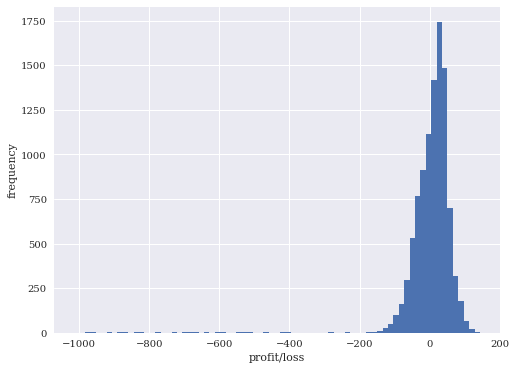

In [33]:
plot_hedge_histogram(pl_list)